In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib ipympl
plt.rcParams['figure.figsize'] = [7, 6]

import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
import lsst.afw.cameraGeom as cameraGeom
import lsst.afw.cameraGeom.utils as cgUtils
import lsst.afw.math as afwMath

afwDisplay.setDefaultBackend("matplotlib")   # you may prefer ds9

In [2]:
# For some reason we need to run this command twice to get interactive plots
%matplotlib ipympl

## Create the IsrTask

In [3]:
from lsst.ip.isr import IsrTask

config = IsrTask.ConfigClass()
if False:
    config.overscanFitType = "AKIMA_SPLINE"
    config.overscanOrder = 5
else:
    config.overscanFitType = "POLY"
    config.overscanOrder = 3
config.doBias = True
config.doDark = False
config.doFringe = False
config.doFlat = False
config.doLinearize = False
config.doDefect = True
config.doAddDistortionModel = False
config.doSaturationInterpolation = False
config.overscanNumLeadingColumnsToSkip = 20

isrTask = IsrTask(config=config)

In [4]:
rerun = "rhl/tmp"

repo = os.path.join('/project/shared/auxTel')
if rerun:
    repo = os.path.join(repo, 'rerun', rerun)

butler = dafPersist.Butler(repo)

dataId = dict(dayObs="2019-03-08")

camera = butler.get('camera')

Explicit dark time not found, setting dark time to the exposure time.
Unable to determine observation type. Guessing 'unknown'


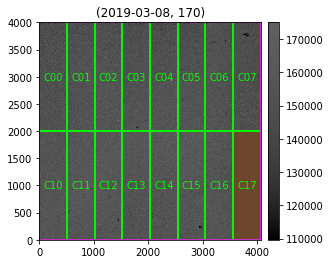

In [5]:
plt.close('all')

seqNum = 170
# Read the data
exposure = butler.get('raw', dataId, seqNum=seqNum)
# Read the calibs if needed (you probably only need do this once)
bias = butler.get('bias', dataId, seqNum=seqNum) if isrTask.config.doBias else None
visit = butler.queryMetadata('raw', ['visit'], dataId, seqNum=seqNum)[0]  # bug in gen2
defects = butler.get('defects', dataId, seqNum=seqNum, visit=visit) if isrTask.config.doDefect else None
#
# Run ISR
#
exposure = isrTask.run(exposure, bias=bias, defects=defects).exposure

# Display the answer

disp = afwDisplay.Display(2, reopenPlot=True)
disp.setMaskPlaneColor('SAT', afwDisplay.IGNORE)
disp.setImageColormap('gray')
disp.scale('asinh', 'zscale')

disp.mtv(exposure, title="(%s, %s)" % (dataId["dayObs"], seqNum))

cgUtils.overlayCcdBoxes(exposure.getDetector(), isTrimmed=True, display=disp)